<a href="https://colab.research.google.com/github/anirudhkumar29/db-A-Discontinuity-bounded-Search-for-Kinodynamic-Mobile-Robot-Motion-Planning/blob/main/RMP_Lab_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Implementation of Bug Algorithms (Bug1, Bug2, Tangent Bug)**

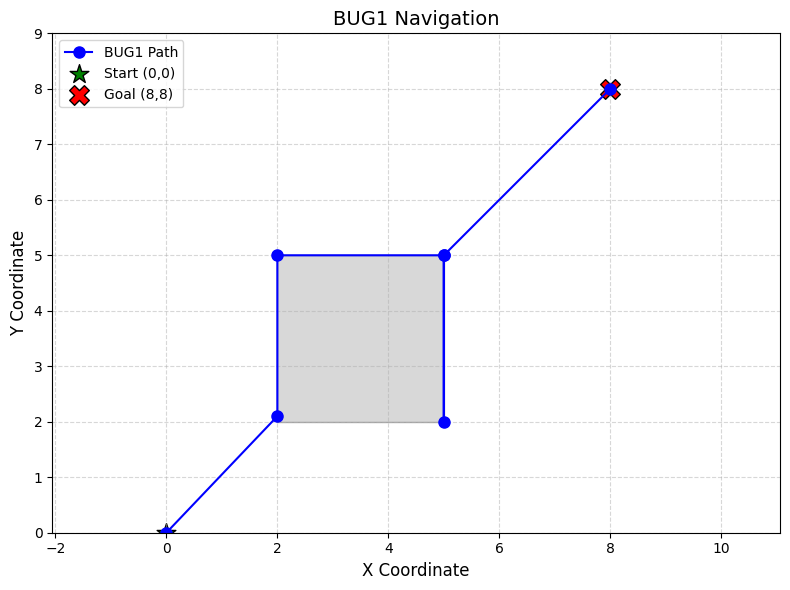

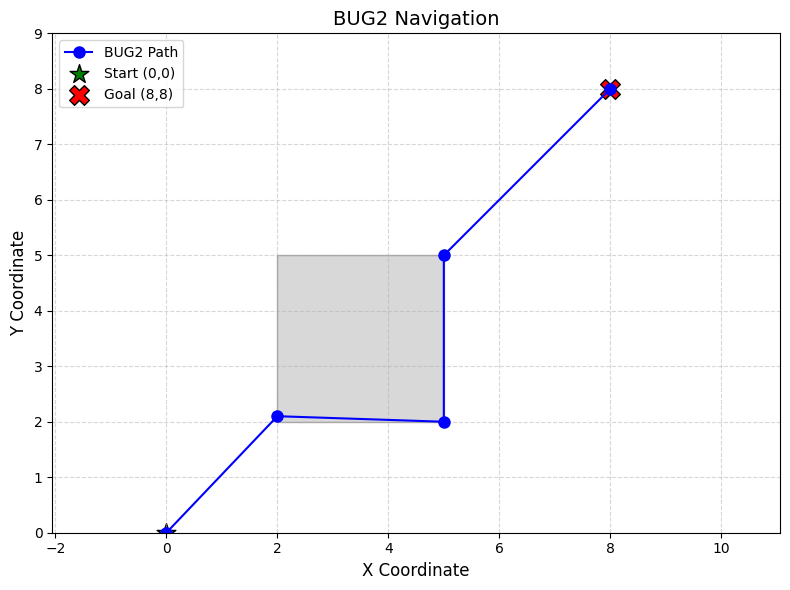

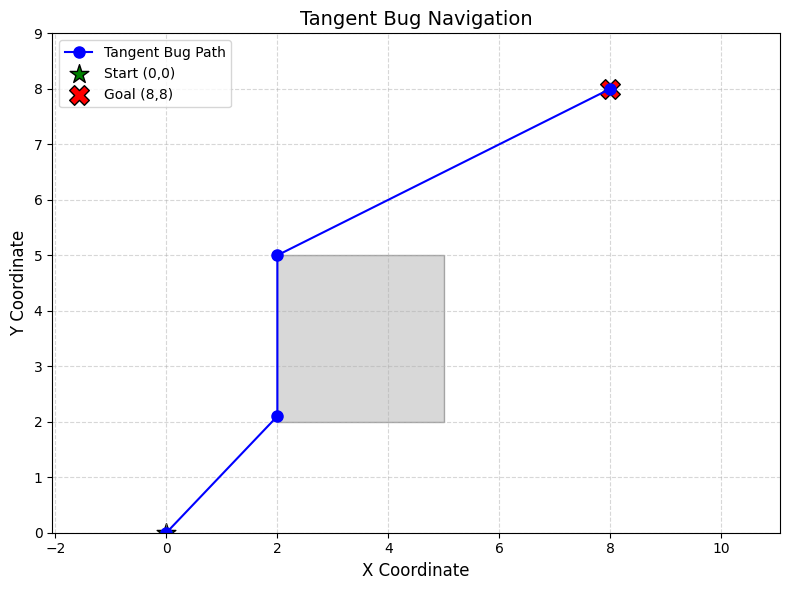

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def plot_individual_algorithm(path, algorithm_name, obstacle_verts):
    plt.figure(figsize=(8, 6))
    ax = plt.gca()

    # Draw obstacle
    obstacle = Polygon(obstacle_verts, closed=True,
                      alpha=0.3, edgecolor='black', facecolor='gray')
    ax.add_patch(obstacle)

    # Plot path
    x, y = zip(*path)
    plt.plot(x, y, 'b-', marker='o', markersize=8,
            label=f'{algorithm_name} Path')

    # Mark start and goal
    plt.scatter(*start, s=200, c='green', edgecolor='black',
                marker='*', label='Start (0,0)')
    plt.scatter(*goal, s=200, c='red', edgecolor='black',
                marker='X', label='Goal (8,8)')

    # Configuration
    plt.title(f'{algorithm_name} Navigation', fontsize=14)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axis('equal')
    plt.xlim(0, 9)
    plt.ylim(0, 9)
    plt.tight_layout()
    plt.show()

# Environment configuration
start = (0, 0)
goal = (8, 8)
obstacle_vertices = [(2, 2), (2, 5), (5, 5), (5, 2)]

# Updated Bug1 path to avoid entering the obstacle
bug1_path = [
    (0, 0),       # Start
    (2, 2.1),     # Hits the obstacle just above bottom-left
    (2, 5),       # Move along the left edge
    (5, 5),       # Top edge
    (5, 2),       # Right edge
    (5, 5),       # (Backtrack to point closest to goal)
    (8, 8)        # Goal
]

# bug1_path = [(0,0), (2,2), (2,5), (5,5), (5,2), (2,2), (5,5), (8,8)]



# Other algorithms for reference
bug2_path = [(0, 0), (2, 2.1), (5, 2), (5, 5), (8, 8)]
tangent_path = [(0, 0), (2, 2.1), (2, 5), (8, 8)]

# Plot all three separately
plot_individual_algorithm(bug1_path, "BUG1", obstacle_vertices)
plot_individual_algorithm(bug2_path, "BUG2", obstacle_vertices)
plot_individual_algorithm(tangent_path, "Tangent Bug", obstacle_vertices)


## **2 Configuration space exploration**

Path found with 108 steps.


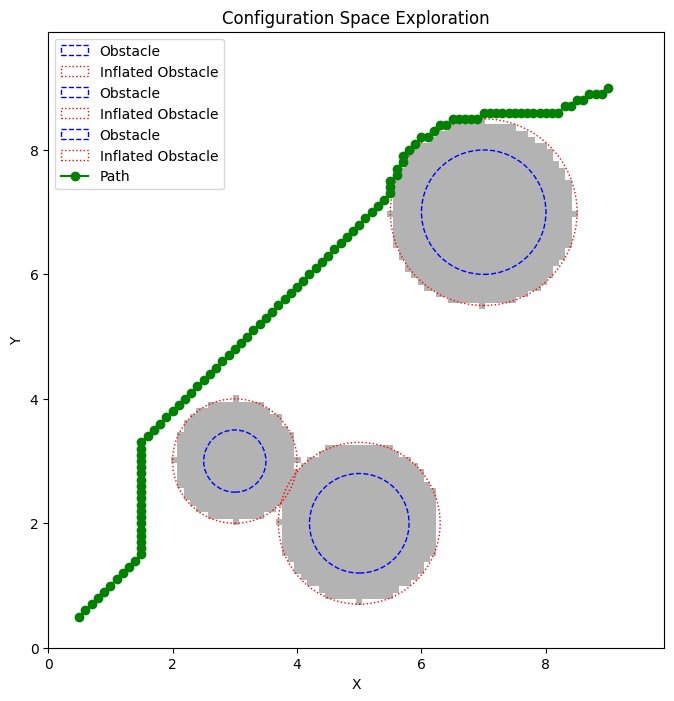

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import heapq



# Utility and Geometry Functions

def distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def inflate_obstacle(obstacle, robot_radius):
    """Inflate a circular obstacle by robot's radius."""
    center, radius = obstacle['center'], obstacle['radius']
    return {'center': center, 'radius': radius + robot_radius}

def point_in_circle(point, circle):
    """Return True if point is inside circle."""
    return distance(point, circle['center']) <= circle['radius']



# A* Search on a Grid (2D)

def astar(grid, start, goal):
    """
    A* search on a grid.
    grid: 2D numpy array where 0 indicates free space and 1 indicates obstacle.
    start, goal: (row, col) indices.
    Returns path as list of grid indices.
    """
    rows, cols = grid.shape
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: distance(start, goal)}

    neighbors = [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]

    while open_set:
        current = heapq.heappop(open_set)[1]
        if current == goal:
            # Reconstruct path
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1]

        for dx, dy in neighbors:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols:
                if grid[neighbor] == 1:
                    continue
                tentative_g = g_score[current] + distance(current, neighbor)
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f_score[neighbor] = tentative_g + distance(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
    return None



# Configuration Space Exploration

def create_configuration_space(width, height, obstacles, robot_radius, resolution=0.1):
    """
    Create a grid for the configuration space.
    width, height: dimensions of the workspace.
    obstacles: list of obstacles in the form {'center': (x, y), 'radius': r}.
    robot_radius: radius of the circular robot.
    resolution: size of each grid cell.
    Returns:
     - grid: 2D numpy array, 0 is free and 1 is occupied.
     - x_vals, y_vals: arrays representing grid coordinates.
    """
    # Determine grid size
    x_vals = np.arange(0, width, resolution)
    y_vals = np.arange(0, height, resolution)
    grid = np.zeros((len(y_vals), len(x_vals)), dtype=int)

    # Inflate obstacles for configuration space
    inflated_obs = [inflate_obstacle(obs, robot_radius) for obs in obstacles]

    # Mark grid cells as occupied if within any inflated obstacle
    for i, y in enumerate(y_vals):
        for j, x in enumerate(x_vals):
            point = (x, y)
            for obs in inflated_obs:
                if point_in_circle(point, obs):
                    grid[i, j] = 1
                    break
    return grid, x_vals, y_vals




# Visualization

def visualize_cspace(grid, x_vals, y_vals, path, obstacles, robot_radius):
    plt.figure(figsize=(8,8))
    # Plot the configuration space grid (occupied cells)
    plt.imshow(grid, origin='lower', extent=(x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]),
               cmap='Greys', alpha=0.3)

    # Plot original obstacles and inflated obstacles
    for obs in obstacles:
        # Original obstacle
        circle1 = plt.Circle(obs['center'], obs['radius'], color='blue', fill=False, linestyle='--', label='Obstacle')
        plt.gca().add_patch(circle1)
        # Inflated obstacle for C-space
        inflated = inflate_obstacle(obs, robot_radius)
        circle2 = plt.Circle(inflated['center'], inflated['radius'], color='red', fill=False, linestyle=':', label='Inflated Obstacle')
        plt.gca().add_patch(circle2)

    # Plot the computed path (convert grid indices back to coordinates)
    if path is not None:
        coords = [(x_vals[j], y_vals[i]) for i, j in path]
        xs, ys = zip(*coords)
        plt.plot(xs, ys, marker='o', color='green', label='Path')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Configuration Space Exploration')
    plt.legend(loc='best')
    plt.xlim(0, x_vals[-1])
    plt.ylim(0, y_vals[-1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()




# Main Simulation Function

def simulate_configuration_space():
    # Define workspace dimensions
    width, height = 10, 10
    # Define circular obstacles in the workspace
    obstacles = [
        {'center': (3, 3), 'radius': 0.5},
        {'center': (7, 7), 'radius': 1.0},
        {'center': (5, 2), 'radius': 0.8}
    ]
    # Define robot parameters: here, a circular robot of given radius
    robot_radius = 0.5

    # Create configuration space grid
    grid, x_vals, y_vals = create_configuration_space(width, height, obstacles, robot_radius, resolution=0.1)

    # Convert start and goal positions to grid indices
    start = (0.5, 0.5)
    goal = (9, 9)
    # Find nearest grid indices for start and goal
    def to_index(p, x_vals, y_vals):
        x, y = p
        j = np.argmin(np.abs(x_vals - x))
        i = np.argmin(np.abs(y_vals - y))
        return (i, j)
    start_idx = to_index(start, x_vals, y_vals)
    goal_idx = to_index(goal, x_vals, y_vals)

    # Run A* search on the grid
    path = astar(grid, start_idx, goal_idx)
    if path is None:
        print("No path found in configuration space.")
    else:
        print("Path found with", len(path), "steps.")

    # Visualize the results
    visualize_cspace(grid, x_vals, y_vals, path, obstacles, robot_radius)

if __name__ == "__main__":
    simulate_configuration_space()


**3. Developing attractive and repulsive potential fields**

<ipython-input-18-7e792ae9483c>:34: RuntimeWarning: divide by zero encountered in divide
  U_rep[mask] = 0.5 * k_rep * (1.0 / distance[mask] - 1.0 / rho_0)**2


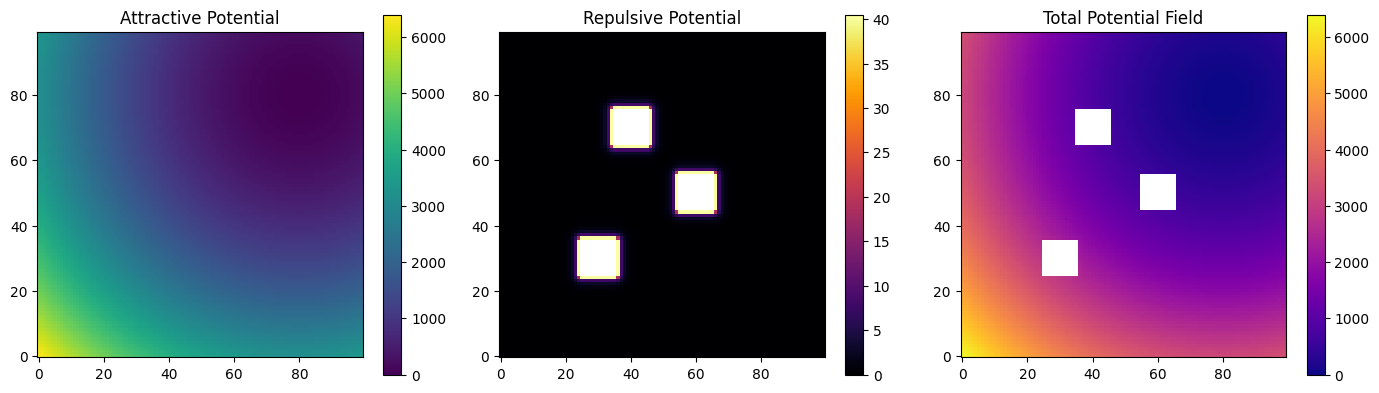

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

# Parameters
grid_size = (100, 100)
goal = np.array([80, 80])
obstacles = [(30, 30), (50, 60), (70, 40)]
obs_radius = 5

k_att = 1.0       # attractive gain
k_rep = 100.0     # repulsive gain
rho_0 = 10        # influence radius for repulsive potential

# Create the environment
env = np.ones(grid_size)
for (x, y) in obstacles:
    for dx in range(-obs_radius, obs_radius+1):
        for dy in range(-obs_radius, obs_radius+1):
            if 0 <= x+dx < grid_size[0] and 0 <= y+dy < grid_size[1]:
                env[x+dx, y+dy] = 0  # obstacle

# Distance transform for repulsive field
obstacle_map = 1 - env
distance = distance_transform_edt(env)

# Attractive Potential
x, y = np.meshgrid(np.arange(grid_size[0]), np.arange(grid_size[1]), indexing='ij')
U_att = 0.5 * k_att * ((x - goal[0])**2 + (y - goal[1])**2)

# Repulsive Potential
U_rep = np.zeros_like(U_att)
mask = distance <= rho_0
U_rep[mask] = 0.5 * k_rep * (1.0 / distance[mask] - 1.0 / rho_0)**2

# Total Potential Field
U_total = U_att + U_rep

# Visualizations
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.title("Attractive Potential")
plt.imshow(U_att, origin='lower', cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Repulsive Potential")
plt.imshow(U_rep, origin='lower', cmap='inferno')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Total Potential Field")
plt.imshow(U_total, origin='lower', cmap='plasma')
plt.colorbar()

plt.tight_layout()
plt.show()


**4. Graph search and roadmap construction**

Found a path with 11 nodes.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


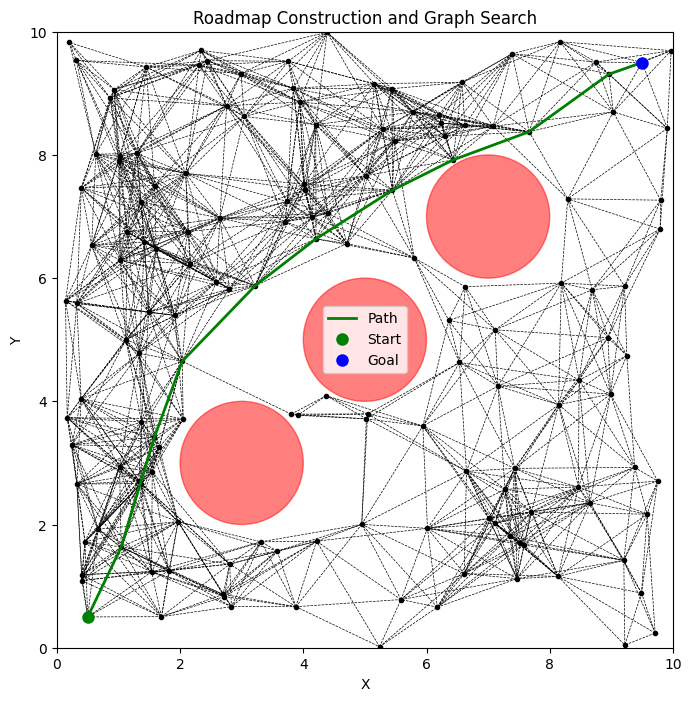

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx




# Collision Checking Functions

def point_in_circle(point, circle):
    """
    Check if a point is inside a circular obstacle.
    circle: dict with keys 'center' (tuple) and 'radius'
    """
    return np.linalg.norm(np.array(point) - np.array(circle['center'])) <= circle['radius']

def line_intersects_circle(p1, p2, circle):
    """
    Check if the line segment from p1 to p2 intersects a circle.
    p1, p2: Points as (x, y).
    circle: dictionary with keys 'center' and 'radius'.
    Returns True if the segment collides with the circle.
    """
    center = np.array(circle['center'])
    p1 = np.array(p1)
    p2 = np.array(p2)
    d = p2 - p1
    f = p1 - center

    a = np.dot(d, d)
    b = 2 * np.dot(f, d)
    c = np.dot(f, f) - circle['radius']**2

    discriminant = b**2 - 4 * a * c
    if discriminant < 0:
        # No intersection if discriminant is negative.
        return False

    discriminant = np.sqrt(discriminant)
    t1 = (-b - discriminant) / (2 * a)
    t2 = (-b + discriminant) / (2 * a)

    # Check if either intersection falls within the segment [0,1]
    if (0 <= t1 <= 1) or (0 <= t2 <= 1):
        return True
    return False

def is_collision_free(p1, p2, obstacles):
    """
    Check that the path (straight-line) from p1 to p2 does not collide with any obstacle.
    """
    for obs in obstacles:
        if line_intersects_circle(p1, p2, obs):
            return False
    return True

def is_point_free(p, obstacles):
    """
    Check whether a point is collision free (not inside any obstacle).
    """
    for obs in obstacles:
        if point_in_circle(p, obs):
            return False
    return True




# Roadmap Construction (Probabilistic Roadmap - PRM)

def construct_roadmap(num_samples, workspace, obstacles, connection_radius):
    """
    Sample free nodes and construct a roadmap.

    Parameters:
      num_samples: Number of random free nodes.
      workspace: dict with keys 'xmin', 'xmax', 'ymin', 'ymax'.
      obstacles: list of circular obstacles.
      connection_radius: maximum distance to connect nodes.

    Returns:
      nodes: list of free nodes [(x, y), ...]
      G: networkx Graph with nodes and weighted edges.
    """
    nodes = []
    xmin, xmax = workspace['xmin'], workspace['xmax']
    ymin, ymax = workspace['ymin'], workspace['ymax']

    # Sample nodes until we have enough free ones.
    while len(nodes) < num_samples:
        p = (np.random.uniform(xmin, xmax), np.random.uniform(ymin, ymax))
        if is_point_free(p, obstacles):
            nodes.append(p)

    # Create graph and add nodes.
    G = nx.Graph()
    for i, p in enumerate(nodes):
        G.add_node(i, pos=p)

    # Attempt to connect each pair of nodes that are close enough.
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if np.linalg.norm(np.array(nodes[i]) - np.array(nodes[j])) <= connection_radius:
                # Check if the direct path is collision-free.
                if is_collision_free(nodes[i], nodes[j], obstacles):
                    weight = np.linalg.norm(np.array(nodes[i]) - np.array(nodes[j]))
                    G.add_edge(i, j, weight=weight)
    return nodes, G




# Insert Start and Goal into the Roadmap

def add_start_goal(G, nodes, start, goal, obstacles, connection_radius):
    """
    Insert start and goal nodes into the graph by connecting them to nearby nodes.
    """
    # Append start and goal to nodes list
    start_idx = len(nodes)
    nodes.append(start)
    goal_idx = len(nodes)
    nodes.append(goal)

    G.add_node(start_idx, pos=start)
    G.add_node(goal_idx, pos=goal)

    # For each new node, connect to existing nodes if feasible
    for idx in [start_idx, goal_idx]:
        for i, p in enumerate(nodes[:-2]):
            if np.linalg.norm(np.array(nodes[idx]) - np.array(p)) <= connection_radius:
                if is_collision_free(nodes[idx], p, obstacles):
                    weight = np.linalg.norm(np.array(nodes[idx]) - np.array(p))
                    G.add_edge(idx, i, weight=weight)
    return start_idx, goal_idx




# Graph Search for the Roadmap

def search_roadmap(G, start_idx, goal_idx):
    """
    Use Dijkstra's algorithm to compute the shortest path from start to goal in G.
    """
    try:
        path = nx.shortest_path(G, source=start_idx, target=goal_idx, weight='weight')
        return path
    except nx.NetworkXNoPath:
        return None



# Visualization of Roadmap and Path

def visualize_roadmap(nodes, G, path, obstacles, workspace):
    plt.figure(figsize=(8, 8))
    # Plot obstacles
    for obs in obstacles:
        circle = plt.Circle(obs['center'], obs['radius'], color='red', fill=True, alpha=0.5)
        plt.gca().add_patch(circle)

    # Plot graph edges
    for (i, j) in G.edges():
        p1 = nodes[i]
        p2 = nodes[j]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k--', linewidth=0.5)

    # Plot nodes
    ns = np.array(nodes)
    plt.plot(ns[:,0], ns[:,1], 'ko', markersize=3)

    # Plot the solution path, if found.
    if path is not None:
        path_coords = [nodes[i] for i in path]
        xs, ys = zip(*path_coords)
        plt.plot(xs, ys, 'g-', linewidth=2, label='Path')

    # Plot start and goal
    start = nodes[path[0]] if path is not None else nodes[-2]
    goal = nodes[path[-1]] if path is not None else nodes[-1]
    plt.plot(start[0], start[1], 'go', markersize=8, label='Start')
    plt.plot(goal[0], goal[1], 'bo', markersize=8, label='Goal')

    plt.xlim(workspace['xmin'], workspace['xmax'])
    plt.ylim(workspace['ymin'], workspace['ymax'])
    plt.title('Roadmap Construction and Graph Search')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()



# Main Function: Roadmap Construction and Graph Search

def roadmap_planning():
    # Define workspace dimensions.
    workspace = {'xmin': 0, 'xmax': 10, 'ymin': 0, 'ymax': 10}

    # Define circular obstacles.
    obstacles = [
        {'center': (3, 3), 'radius': 1.0},
        {'center': (7, 7), 'radius': 1.0},
        {'center': (5, 5), 'radius': 1.0}
    ]

    # Parameters for the roadmap.
    num_samples = 150          # Number of sample nodes
    connection_radius = 2.0    # Maximum distance to connect two nodes

    # Construct the roadmap.
    nodes, G = construct_roadmap(num_samples, workspace, obstacles, connection_radius)

    # Define start and goal positions.
    start = (0.5, 0.5)
    goal = (9.5, 9.5)

    # Add start and goal to the graph.
    start_idx, goal_idx = add_start_goal(G, nodes, start, goal, obstacles, connection_radius)

    # Search the roadmap to find a path.
    path = search_roadmap(G, start_idx, goal_idx)
    if path is None:
        print("No path found between the start and goal.")
    else:
        print("Found a path with", len(path), "nodes.")

    # Visualize the roadmap and the path.
    visualize_roadmap(nodes, G, path, obstacles, workspace)

if __name__ == "__main__":
    roadmap_planning()


**5. Probabilistic Roadmaps and RRT**

Running PRM Planner...
PRM found a path with 11 nodes.


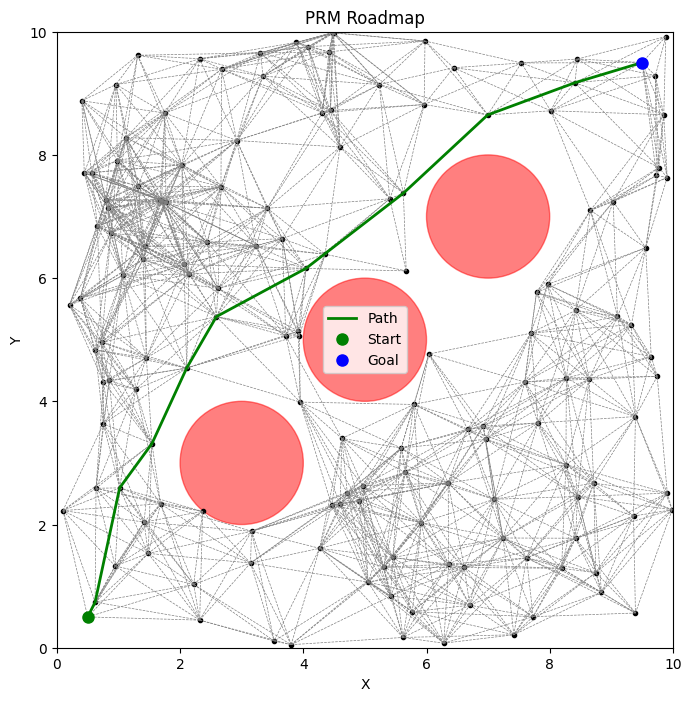

Running RRT Planner...
RRT reached goal in 126 iterations.
RRT path found with 30 nodes.


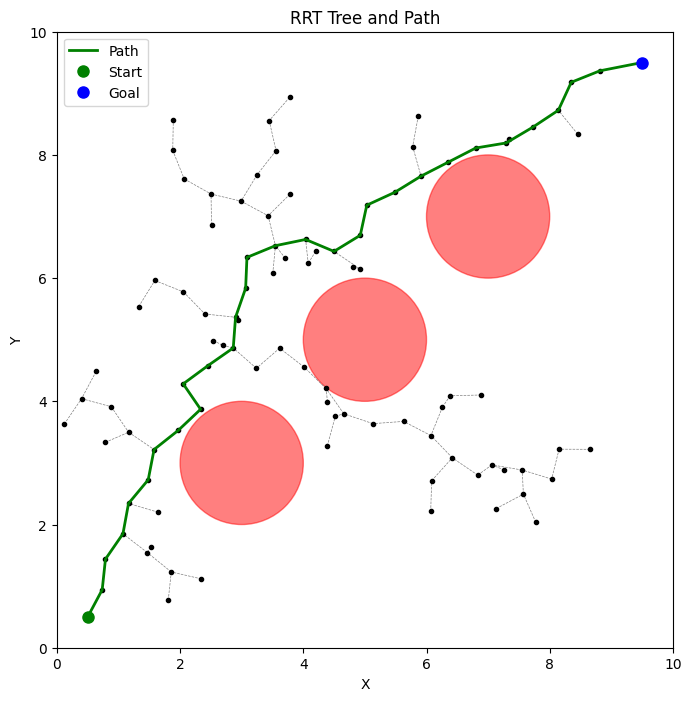

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random



# Utility: Collision checking functions for circular obstacles

def point_in_circle(point, circle):
    """Return True if the point is inside the given circular obstacle."""
    return np.linalg.norm(np.array(point) - np.array(circle['center'])) <= circle['radius']

def line_intersects_circle(p1, p2, circle):
    """
    Check if the line segment between p1 and p2 intersects a circular obstacle.
    p1, p2: (x, y) tuples.
    circle: dict with keys 'center' and 'radius'.
    """
    center = np.array(circle['center'])
    p1 = np.array(p1)
    p2 = np.array(p2)
    d = p2 - p1
    f = p1 - center

    a = np.dot(d, d)
    b = 2 * np.dot(f, d)
    c = np.dot(f, f) - circle['radius']**2

    discriminant = b**2 - 4 * a * c
    if discriminant < 0:
        return False  # no intersection
    discriminant = np.sqrt(discriminant)
    t1 = (-b - discriminant) / (2 * a)
    t2 = (-b + discriminant) / (2 * a)
    if (0 <= t1 <= 1) or (0 <= t2 <= 1):
        return True
    return False

def is_collision_free(p1, p2, obstacles):
    """
    Check that the straight-line path between p1 and p2 does not intersect any obstacle.
    """
    for obs in obstacles:
        if line_intersects_circle(p1, p2, obs):
            return False
    return True

def is_point_free(p, obstacles):
    """Return True if the point is not inside any obstacle."""
    for obs in obstacles:
        if point_in_circle(p, obs):
            return False
    return True




# 1. Probabilistic Roadmap (PRM) Implementation

def construct_prm(num_samples, workspace, obstacles, connection_radius):
    """
    Sample free nodes and construct a roadmap.

    Parameters:
      num_samples: number of free nodes to sample.
      workspace: dict with keys 'xmin', 'xmax', 'ymin', 'ymax'.
      obstacles: list of circular obstacles.
      connection_radius: maximum distance to try to connect nodes.

    Returns:
      nodes: list of (x,y) positions.
      G: networkx Graph where edges have weight equal to Euclidean distance.
    """
    nodes = []
    xmin, xmax = workspace['xmin'], workspace['xmax']
    ymin, ymax = workspace['ymin'], workspace['ymax']

    # Randomly sample nodes and check for collisions.
    while len(nodes) < num_samples:
        p = (np.random.uniform(xmin, xmax), np.random.uniform(ymin, ymax))
        if is_point_free(p, obstacles):
            nodes.append(p)

    # Build the graph.
    G = nx.Graph()
    for i, p in enumerate(nodes):
        G.add_node(i, pos=p)
    # Connect nearby nodes with collision-free edges.
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if np.linalg.norm(np.array(nodes[i]) - np.array(nodes[j])) <= connection_radius:
                if is_collision_free(nodes[i], nodes[j], obstacles):
                    weight = np.linalg.norm(np.array(nodes[i]) - np.array(nodes[j]))
                    G.add_edge(i, j, weight=weight)
    return nodes, G

def add_prm_start_goal(G, nodes, start, goal, obstacles, connection_radius):

    start_idx = len(nodes)
    nodes.append(start)
    goal_idx = len(nodes)
    nodes.append(goal)
    G.add_node(start_idx, pos=start)
    G.add_node(goal_idx, pos=goal)
    for idx in [start_idx, goal_idx]:
        for i, p in enumerate(nodes[:-2]):
            if np.linalg.norm(np.array(nodes[idx]) - np.array(p)) <= connection_radius:
                if is_collision_free(nodes[idx], p, obstacles):
                    weight = np.linalg.norm(np.array(nodes[idx]) - np.array(p))
                    G.add_edge(idx, i, weight=weight)
    return start_idx, goal_idx

def prm_planner(num_samples=150, connection_radius=2.0):
    """
    Execute PRM-based planning in a simple workspace.
    """
    # Define workspace and obstacles.
    workspace = {'xmin': 0, 'xmax': 10, 'ymin': 0, 'ymax': 10}
    obstacles = [
        {'center': (3, 3), 'radius': 1.0},
        {'center': (7, 7), 'radius': 1.0},
        {'center': (5, 5), 'radius': 1.0}
    ]
    start = (0.5, 0.5)
    goal = (9.5, 9.5)

    nodes, G = construct_prm(num_samples, workspace, obstacles, connection_radius)
    start_idx, goal_idx = add_prm_start_goal(G, nodes, start, goal, obstacles, connection_radius)

    # Use Dijkstra's algorithm (or A*) to search for the shortest path.
    try:
        path_indices = nx.shortest_path(G, source=start_idx, target=goal_idx, weight='weight')
        print("PRM found a path with", len(path_indices), "nodes.")
    except nx.NetworkXNoPath:
        print("PRM found no path.")
        path_indices = None

    # Visualize
    visualize_planner(nodes, G, path_indices, obstacles, workspace, method="PRM")





# 2. Rapidly-Exploring Random Tree (RRT) Implementation

def get_nearest(tree, q_rand):
    """
    Return the index and value of the tree node nearest to q_rand.
    """
    min_dist = np.inf
    nearest_idx = None
    for idx, q in tree.items():
        d = np.linalg.norm(np.array(q) - np.array(q_rand))
        if d < min_dist:
            min_dist = d
            nearest_idx = idx
    return nearest_idx, tree[nearest_idx]

def steer(q_near, q_rand, step_size):
    """
    Move from q_near toward q_rand by at most step_size.
    """
    q_near = np.array(q_near)
    q_rand = np.array(q_rand)
    direction = q_rand - q_near
    dist = np.linalg.norm(direction)
    if dist <= step_size:
        return tuple(q_rand)
    else:
        return tuple(q_near + (direction/dist)*step_size)

def rrt_planner(start, goal, obstacles, workspace, step_size=0.5, max_iter=1000, goal_sample_rate=0.1):
    """
    Implement the RRT algorithm.

    Parameters:
      start, goal: (x, y) tuples.
      obstacles: list of circular obstacles.
      workspace: dict with workspace limits.
      step_size: incremental step size for expansion.
      max_iter: maximum number of iterations.
      goal_sample_rate: probability of sampling the goal directly.

    Returns:
      tree: dictionary mapping node indices to (x,y) coordinates.
      parent: dictionary that maps child indices to the index of its parent.
      goal_idx: index of goal node if reached, else None.
    """
    tree = {}
    parent = {}
    tree[0] = start
    parent[0] = None
    node_index = 1
    for it in range(max_iter):
        # With a probability, sample the goal to bias tree growth.
        if random.random() < goal_sample_rate:
            q_rand = goal
        else:
            q_rand = (np.random.uniform(workspace['xmin'], workspace['xmax']),
                      np.random.uniform(workspace['ymin'], workspace['ymax']))
        # Skip q_rand if it is in collision.
        if not is_point_free(q_rand, obstacles):
            continue
        # Find nearest node in the tree.
        near_idx, q_near = get_nearest(tree, q_rand)
        # Steer toward q_rand.
        q_new = steer(q_near, q_rand, step_size)
        # Check collision along the edge.
        if is_collision_free(q_near, q_new, obstacles):
            tree[node_index] = q_new
            parent[node_index] = near_idx
            # Check if goal is reached.
            if np.linalg.norm(np.array(q_new) - np.array(goal)) < step_size:
                tree[node_index] = goal  # Ensure exact goal
                parent[node_index] = near_idx
                print("RRT reached goal in", it, "iterations.")
                return tree, parent, node_index
            node_index += 1
    print("RRT failed to reach goal after max iterations.")
    return tree, parent, None

def extract_rrt_path(tree, parent, goal_idx):
    """
    Reconstruct the path from start to goal in the RRT.
    """
    path = []
    idx = goal_idx
    while idx is not None:
        path.append(tree[idx])
        idx = parent[idx]
    path.reverse()
    return path

def rrt_planner_wrapper():
    """
    Run RRT planning and visualize the result.
    """
    workspace = {'xmin': 0, 'xmax': 10, 'ymin': 0, 'ymax': 10}
    obstacles = [
        {'center': (3, 3), 'radius': 1.0},
        {'center': (7, 7), 'radius': 1.0},
        {'center': (5, 5), 'radius': 1.0}
    ]
    start = (0.5, 0.5)
    goal = (9.5, 9.5)
    tree, parent, goal_idx = rrt_planner(start, goal, obstacles, workspace,
                                          step_size=0.5, max_iter=2000, goal_sample_rate=0.1)
    if goal_idx is not None:
        path = extract_rrt_path(tree, parent, goal_idx)
        print("RRT path found with", len(path), "nodes.")
    else:
        path = None
        print("No path was found by RRT.")
    visualize_rrt(tree, parent, path, obstacles, workspace, start, goal)




# Visualization Functions for Both Planners

def visualize_planner(nodes, G, path_indices, obstacles, workspace, method="PRM"):
    plt.figure(figsize=(8, 8))
    # Plot obstacles.
    for obs in obstacles:
        circle = plt.Circle(obs['center'], obs['radius'], color='red', alpha=0.5)
        plt.gca().add_patch(circle)
    # Plot all nodes (for PRM, sample nodes).
    ns = np.array(nodes)
    plt.plot(ns[:,0], ns[:,1], 'ko', markersize=3)
    # Plot roadmap edges.
    for (i, j) in G.edges():
        p1 = nodes[i]
        p2 = nodes[j]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'gray', linestyle='--', linewidth=0.5)
    # Plot solution path if found.
    if path_indices is not None:
        path_coords = [nodes[i] for i in path_indices]
        xs, ys = zip(*path_coords)
        plt.plot(xs, ys, 'g-', linewidth=2, label='Path')
        plt.plot(xs[0], ys[0], 'go', markersize=8, label='Start')
        plt.plot(xs[-1], ys[-1], 'bo', markersize=8, label='Goal')
    plt.title(method + " Roadmap")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xlim(workspace['xmin'], workspace['xmax'])
    plt.ylim(workspace['ymin'], workspace['ymax'])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()

def visualize_rrt(tree, parent, path, obstacles, workspace, start, goal):
    plt.figure(figsize=(8,8))
    # Plot obstacles.
    for obs in obstacles:
        circle = plt.Circle(obs['center'], obs['radius'], color='red', alpha=0.5)
        plt.gca().add_patch(circle)
    # Plot all tree edges.
    for idx, q in tree.items():
        if parent[idx] is not None:
            p_parent = tree[parent[idx]]
            plt.plot([q[0], p_parent[0]], [q[1], p_parent[1]], 'gray', linestyle='--', linewidth=0.5)
    # Plot tree nodes.
    qs = np.array(list(tree.values()))
    plt.plot(qs[:,0], qs[:,1], 'ko', markersize=3)
    # If a path exists, plot it.
    if path is not None:
        xs, ys = zip(*path)
        plt.plot(xs, ys, 'g-', linewidth=2, label='Path')
        plt.plot(start[0], start[1], 'go', markersize=8, label='Start')
        plt.plot(goal[0], goal[1], 'bo', markersize=8, label='Goal')
    plt.title("RRT Tree and Path")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xlim(workspace['xmin'], workspace['xmax'])
    plt.ylim(workspace['ymin'], workspace['ymax'])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()



# Main Function to Run and Compare PRM and RRT
def main():
    print("Running PRM Planner...")
    prm_planner(num_samples=150, connection_radius=2.0)

    print("Running RRT Planner...")
    rrt_planner_wrapper()

if __name__ == "__main__":
    main()
